In [3]:
!pip install tensorflow keras numpy matplotlib opencv-python pillow flask-ngrok

Loaded 10000 samples for cat
Loaded 10000 samples for dog
Loaded 10000 samples for house
Error loading tree: cannot reshape array of size 18489264 into shape (144721,784)
Loaded 10000 samples for car
Loaded 10000 samples for apple
Loaded 10000 samples for banana
Loaded 10000 samples for clock
Data preparation complete!
Training data shape: (50400, 28, 28, 1)
Validation data shape: (5600, 28, 28, 1)
Test data shape: (14000, 28, 28, 1)
Categories: ['cat', 'dog', 'house', 'tree', 'car', 'apple', 'banana', 'clock']


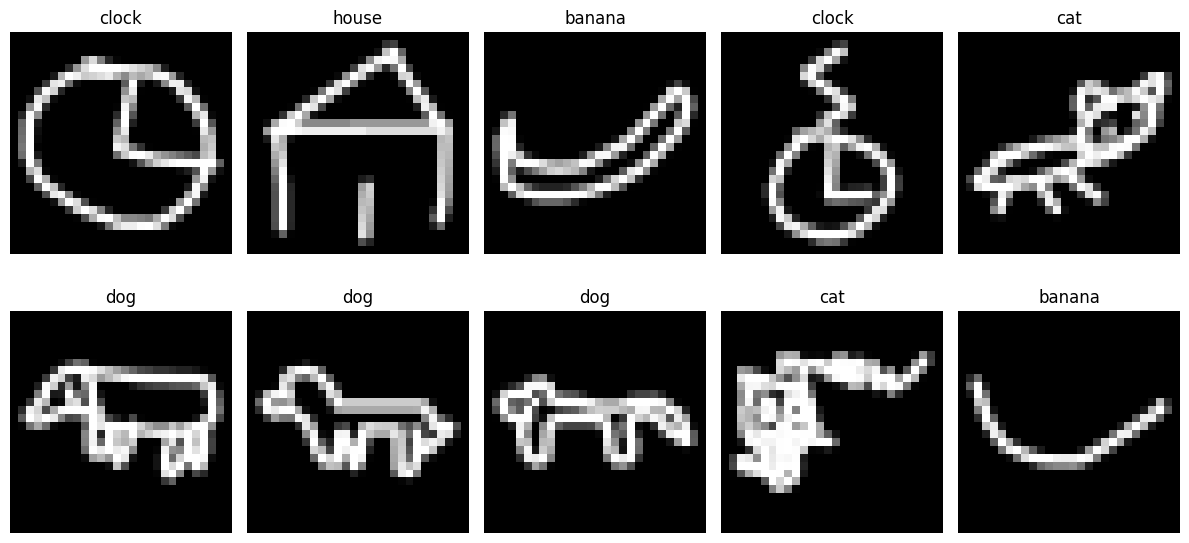

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 539,240 (2.06 MB)

 Trainable params: 537,064 (2.05 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5798 - loss: 2.1903

393/393 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.5801 - loss: 2.1890 - val_accuracy: 0.1923 - val_loss: 5.6340 - learning_rate: 0.0010
Epoch 2/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8906 - loss: 1.0833

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8906 - loss: 1.0833 - val_accuracy: 0.1968 - val_loss: 5.6956 - learning_rate: 0.0010
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8560 - loss: 1.0629

393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8561 - loss: 1.0626 - val_accuracy: 0.9195 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8906 - loss: 0.8230 - val_accuracy: 0.9170 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 5/50
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8876 - loss: 0.7376

393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8876 - loss: 0.7373 - val_accuracy: 0.9248 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 0.5931 - val_accuracy: 0.9245 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 7/50
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8998 - loss: 0.5368

393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8998 - loss: 0.5366 - val_accuracy: 0.9302 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9141 - loss: 0.4744 - val_accuracy: 0.9295 - val_loss: 0.3681 - learning_rate: 0.0010
Epoch 9/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9088 - loss: 0.4228 - val_accuracy: 0.9280 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 10/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9141 - loss: 0.4235

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9141 - loss: 0.4235 - val_accuracy: 0.9304 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 11/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9121 - loss: 0.3708

393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9121 - loss: 0.3708 - val_accuracy: 0.9366 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 12/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8828 - loss: 0.4499

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8828 - loss: 0.4499 - val_accuracy: 0.9377 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 13/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9160 - loss: 0.3382 - val_accuracy: 0.9362 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 14/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9141 - loss: 0.3693 - val_accuracy: 0.9364 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 15/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9157 - loss: 0.3301 - val_accuracy: 0.9309 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 16/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.2577 - val_accuracy: 0.9320 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 17/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9197 - loss: 0.3121 - val_accuracy: 0.9316 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 18/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9219 - loss: 0.2630 -

393/393 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9265 - loss: 0.2896 - val_accuracy: 0.9420 - val_loss: 0.2145 - learning_rate: 2.0000e-04
Epoch 20/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9453 - loss: 0.3077

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9453 - loss: 0.3077 - val_accuracy: 0.9421 - val_loss: 0.2144 - learning_rate: 2.0000e-04
Epoch 21/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9329 - loss: 0.2534

393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9328 - loss: 0.2534 - val_accuracy: 0.9430 - val_loss: 0.2021 - learning_rate: 2.0000e-04
Epoch 22/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8984 - loss: 0.4532 - val_accuracy: 0.9429 - val_loss: 0.2019 - learning_rate: 2.0000e-04
Epoch 23/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9336 - loss: 0.2408

393/393 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9336 - loss: 0.2408 - val_accuracy: 0.9445 - val_loss: 0.1939 - learning_rate: 2.0000e-04
Epoch 24/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9609 - loss: 0.1873 - val_accuracy: 0.9443 - val_loss: 0.1939 - learning_rate: 2.0000e-04
Epoch 25/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9341 - loss: 0.2343 - val_accuracy: 0.9430 - val_loss: 0.1883 - learning_rate: 2.0000e-04
Epoch 26/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9609 - loss: 0.2105 - val_accuracy: 0.9436 - val_loss: 0.1884 - learning_rate: 2.0000e-04
Epoch 27/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9339 - loss: 0.2289 - val_accuracy: 0.9434 - val_loss: 0.1815 - learning_rate: 2.0000e-04
Epoch 28/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9297 - loss: 0.2036 - val_accuracy: 0.9434 - val_loss: 0.1817 - learning_rate: 2.0000e-04
Epoch 29/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accurac

393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9362 - loss: 0.2126 - val_accuracy: 0.9446 - val_loss: 0.1752 - learning_rate: 4.0000e-05
Epoch 34/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9609 - loss: 0.1943

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9609 - loss: 0.1943 - val_accuracy: 0.9452 - val_loss: 0.1752 - learning_rate: 4.0000e-05
Epoch 35/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9389 - loss: 0.2085 - val_accuracy: 0.9443 - val_loss: 0.1726 - learning_rate: 4.0000e-05
Epoch 36/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.2196 - val_accuracy: 0.9443 - val_loss: 0.1725 - learning_rate: 4.0000e-05
Epoch 37/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9365 - loss: 0.2093

393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9365 - loss: 0.2092 - val_accuracy: 0.9463 - val_loss: 0.1720 - learning_rate: 4.0000e-05
Epoch 38/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8906 - loss: 0.2944

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8906 - loss: 0.2944 - val_accuracy: 0.9464 - val_loss: 0.1720 - learning_rate: 4.0000e-05
Epoch 39/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9382 - loss: 0.2007 - val_accuracy: 0.9459 - val_loss: 0.1695 - learning_rate: 4.0000e-05
Epoch 40/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1687 - val_accuracy: 0.9463 - val_loss: 0.1695 - learning_rate: 4.0000e-05
Epoch 41/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9404 - loss: 0.1980 - val_accuracy: 0.9464 - val_loss: 0.1674 - learning_rate: 4.0000e-05
Epoch 42/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9297 - loss: 0.2453 - val_accuracy: 0.9464 - val_loss: 0.1674 - learning_rate: 4.0000e-05
Epoch 43/50
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9376 - loss: 0.2039

393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9376 - loss: 0.2039 - val_accuracy: 0.9468 - val_loss: 0.1666 - learning_rate: 4.0000e-05
Epoch 44/50
  1/393 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9375 - loss: 0.1795

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.1795 - val_accuracy: 0.9470 - val_loss: 0.1667 - learning_rate: 4.0000e-05
Epoch 45/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9405 - loss: 0.1958 - val_accuracy: 0.9468 - val_loss: 0.1656 - learning_rate: 4.0000e-05
Epoch 46/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.1909 - val_accuracy: 0.9468 - val_loss: 0.1656 - learning_rate: 4.0000e-05
Epoch 47/50
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9390 - loss: 0.1947

393/393 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9390 - loss: 0.1947 - val_accuracy: 0.9471 - val_loss: 0.1645 - learning_rate: 4.0000e-05
Epoch 48/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.2044 - val_accuracy: 0.9470 - val_loss: 0.1645 - learning_rate: 4.0000e-05
Epoch 49/50
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9413 - loss: 0.1929

393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9413 - loss: 0.1929 - val_accuracy: 0.9473 - val_loss: 0.1630 - learning_rate: 4.0000e-05
Epoch 50/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.1753 - val_accuracy: 0.9473 - val_loss: 0.1630 - learning_rate: 4.0000e-05


Test accuracy: 0.9491


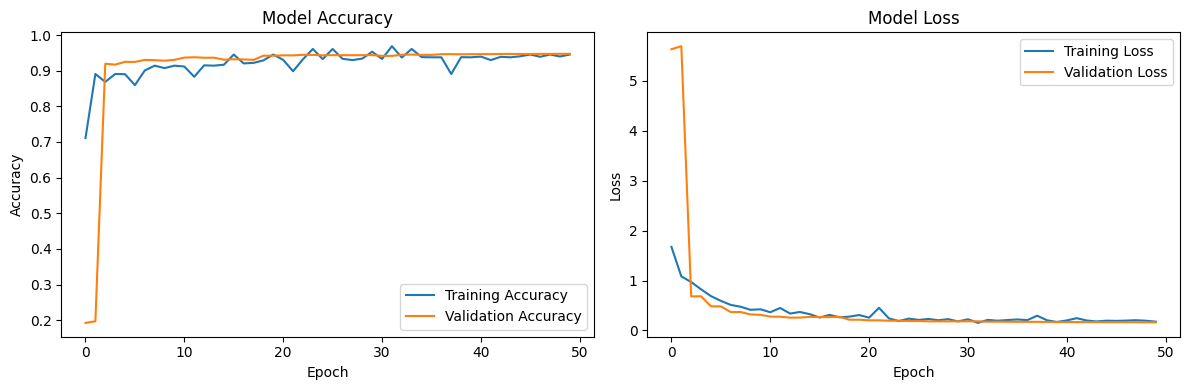

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


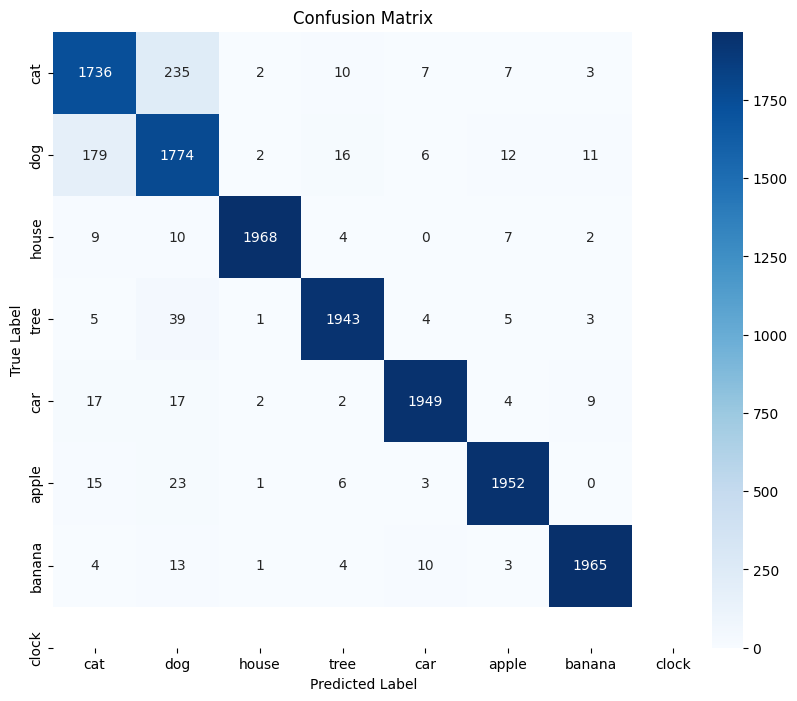

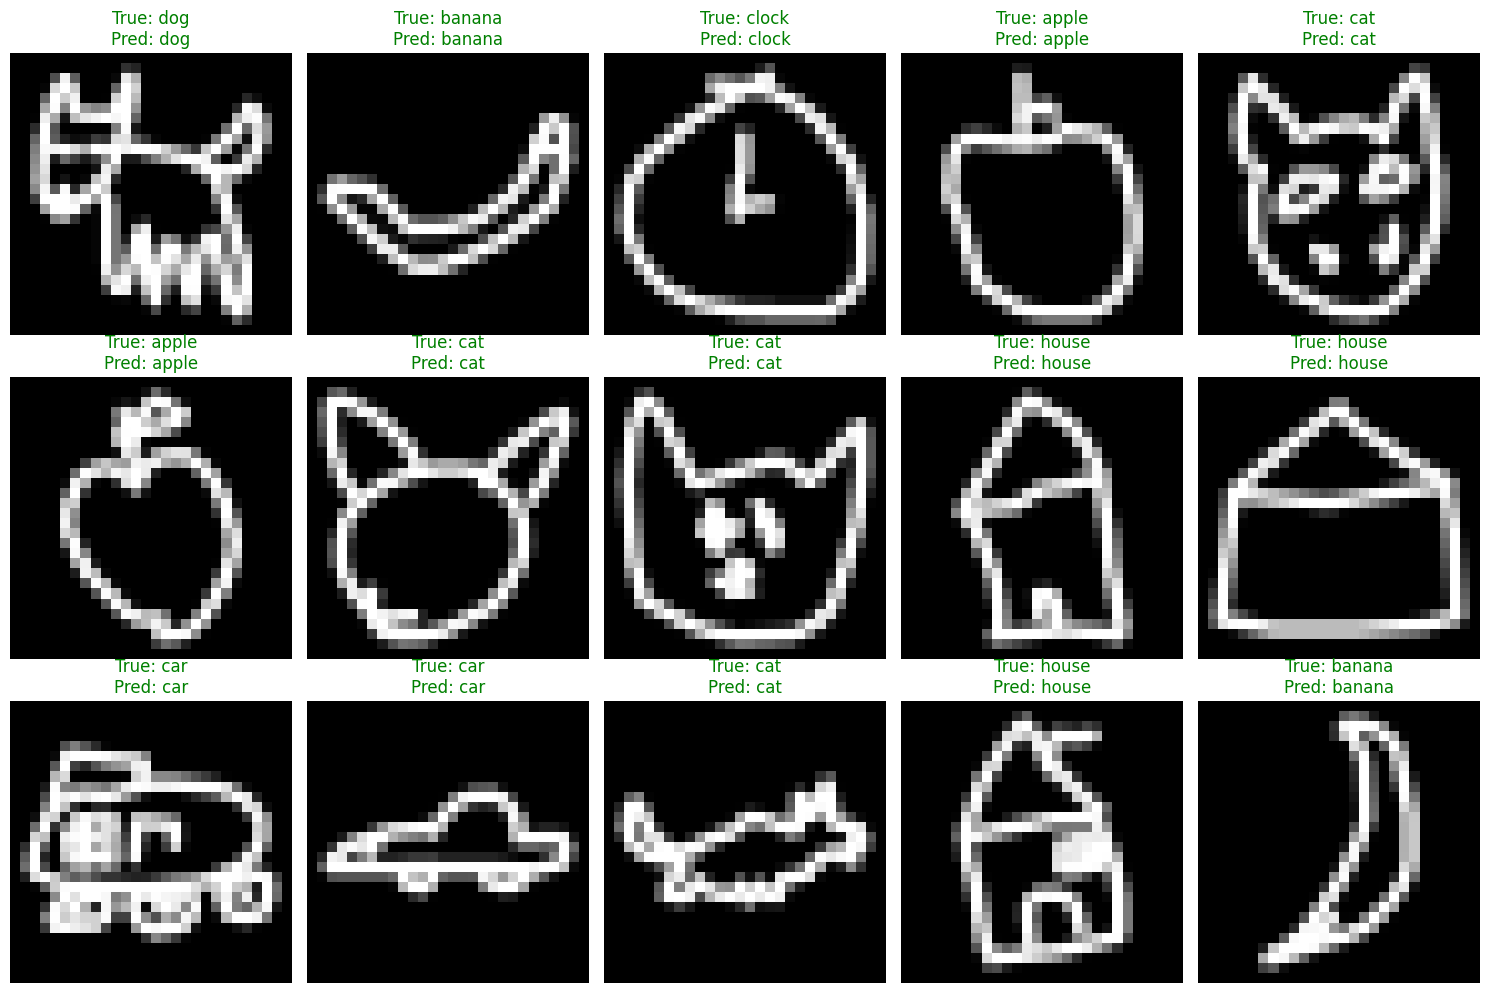

In [5]:
import numpy as np
import os
import requests
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CATEGORIES = ['cat', 'dog', 'house', 'tree', 'car', 'apple', 'banana', 'clock']

def download_quickdraw_data():

    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    data_dir = 'quickdraw_data'

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    X = []
    y = []

    for i, category in enumerate(CATEGORIES):
        filename = f"{category.replace(' ', '%20')}.npy"
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            print(f"Downloading {category} data...")
            try:
                response = requests.get(base_url + filename, stream=True)
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
            except Exception as e:
                print(f"Failed to download {category}: {e}")
                continue

        try:
            category_data = np.load(filepath)
            num_samples = min(10000, len(category_data))
            category_data = category_data[:num_samples]

            category_data = category_data.reshape(-1, 28, 28, 1).astype('float32') / 255.0

            X.append(category_data)
            y.append(np.full(len(category_data), i))

            print(f"Loaded {len(category_data)} samples for {category}")

        except Exception as e:
            print(f"Error loading {category}: {e}")
            continue

    if not X:
        raise ValueError("No data was loaded. Check your internet connection or category names.")

    X = np.vstack(X)
    y = np.hstack(y)

    y = to_categorical(y, num_classes=len(CATEGORIES))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, CATEGORIES

print("Downloading and preprocessing QuickDraw dataset...")
X_train, X_val, X_test, y_train, y_val, y_test, CATEGORIES = download_quickdraw_data()

np.savez('quickdraw_data/preprocessed_data.npz',
         X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         categories=CATEGORIES)

print("Data preparation complete!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Categories: {CATEGORIES}")

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(CATEGORIES[np.argmax(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

def create_improved_model(input_shape, num_classes):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

input_shape = (28, 28, 1)
model = create_improved_model(input_shape, len(CATEGORIES))
model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ModelCheckpoint('best_doodle_model.h5', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

batch_size = 128
epochs = 50

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

model = tf.keras.models.load_model('best_doodle_model.h5')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')

    pred_label = CATEGORIES[y_pred_classes[i]]
    true_label = CATEGORIES[y_true[i]]

    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from google.colab import files

files.download('best_doodle_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>